[*********************100%***********************]  1 of 1 completed


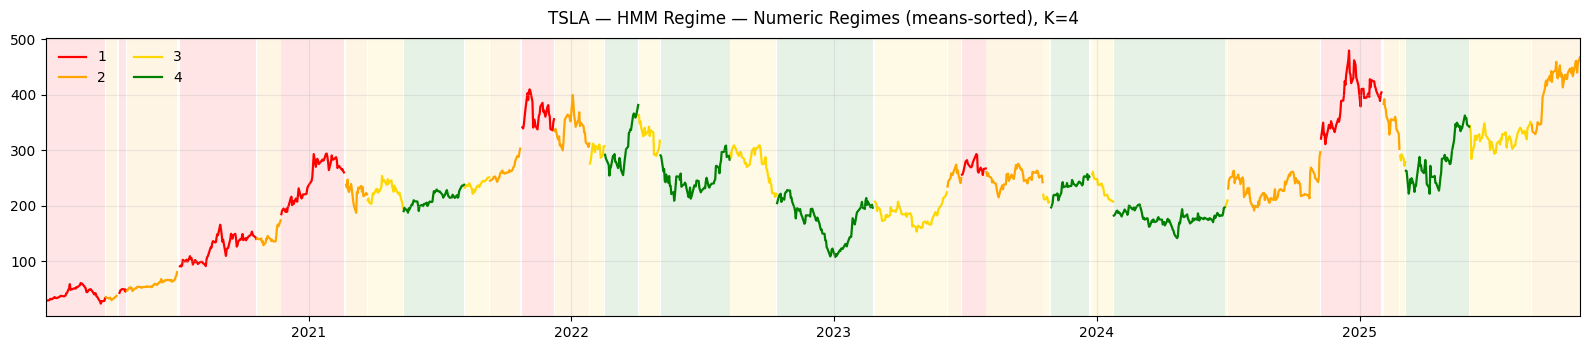


--- HMM Results (K=4) ---
Features Used: ['Level_ATR100', 'Slope_ATR100', 'RSI']
Best log-likelihood: -7607.545105435422
   state  trend_score  mom_score  macd_score  ac1_5_score
3      3    39.020271   0.011298   -0.071232          NaN
0      0    16.838115  -0.027096   -0.122875          NaN
2      2     1.298025   0.944056   -0.381635          NaN
1      1   -14.333336  -0.045586    0.447201          NaN

--- Final Model Regime Characteristics (Unscaled Feature Means) ---
   regime_int regime_eng  Level_ATR100  Slope_ATR100   RSI
3           1       Bull         12.44          0.02 64.55
0           2  Weak Bull          3.79         -0.05 54.76
2           3  Weak Bear          0.60         -0.01 50.97
1           4       Bear         -2.40          0.06 47.78

--- Next Day State Probabilities ---
Based on last state: state=0, regime=2 (Weak Bull)
state | P(next) | regime_int | regime_eng
---------------------------------------
    0 |  96.98% |          2 | Weak Bull
    1 |   0.

In [19]:
from hmm_regime import HMMRegimeAnalyzer, with_regime_index

analyzer = HMMRegimeAnalyzer(
    ticker="TSLA",
    start="2010-01-01",
    plot_start="2020-01-01",
    n_states=4,
    n_trials=20,
    ma_window=120,
    rsi_period=14,
    ac_window=60,
    smoothing_window_mr=1,
    use_slope=True,
    use_ac=False,
    use_rsi=True,
    use_volume=False,
)

df, feats_scaled, model, mapping = analyzer.run()
df_ix = with_regime_index(df)


In [20]:
df['regime'].unique()

array([3, 2, 1, 4])

In [21]:
import pandas as pd
import yfinance as yf

ticker = analyzer.ticker
start  = analyzer.start

# 1) 원시 다운로드 (멀티인덱스까지 고려)
raw = yf.download(ticker, start=start, auto_adjust=True, progress=False)

def _get_ohl_from_yf(df):
    """
    yfinance 단일 티커에서 생기는 케이스 모두 처리해서
    Open/High/Low 각각 1D Series로 리턴.
    """
    def _extract(field: str) -> pd.Series:
        if isinstance(df.columns, pd.MultiIndex):
            lvl0 = df.columns.get_level_values(0)
            lvl1 = df.columns.get_level_values(1)
            # case A: 레벨1에 필드명이 있는 경우
            if field in set(lvl1):
                s = df.xs(field, level=1, axis=1)
            # case B: 레벨0에 필드명이 있는 경우
            elif field in set(lvl0):
                s = df[field]
            else:
                raise KeyError(f"Cannot locate {field} in columns {df.columns}")
            # 단일 티커면 DF일 수 있으니 1D로 납작화
            if isinstance(s, pd.DataFrame):
                s = s.iloc[:, 0]
        else:
            s = df[field]
        return pd.to_numeric(s, errors='coerce').rename(field)

    O = _extract('Open')
    H = _extract('High')
    L = _extract('Low')
    return O, H, L

open_, high, low = _get_ohl_from_yf(raw)

# 2) df와 정렬 맞추고 결합 (df는 기존에 가지고 있던 가격/레짐 DF)
ohl = pd.concat([open_, high, low], axis=1).reindex(df.index)
df_aug = df.join(ohl)

# 3) 표준 컬럼명 보장 + 정렬
df_aug = df_aug.rename(columns={
    'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'Regime':'regime'
})
df_aug = df_aug[~df_aug.index.duplicated(keep='last')].sort_index()

# 4) 멀티인덱스 df_ix, 백테스트용 df_out 생성
df_ix = with_regime_index(df_aug)

df_out = (
    df_aug[['Close','Open','High','Low','regime']]
      .dropna(subset=['Close','Open','High','Low','regime'])
      .assign(regime=lambda x: x['regime'].astype(int))
      .sort_index()
)


In [22]:
import importlib, regime_backtester
importlib.reload(regime_backtester)
from regime_backtester import RegimeBacktester, BTConfig, strategy_attribution

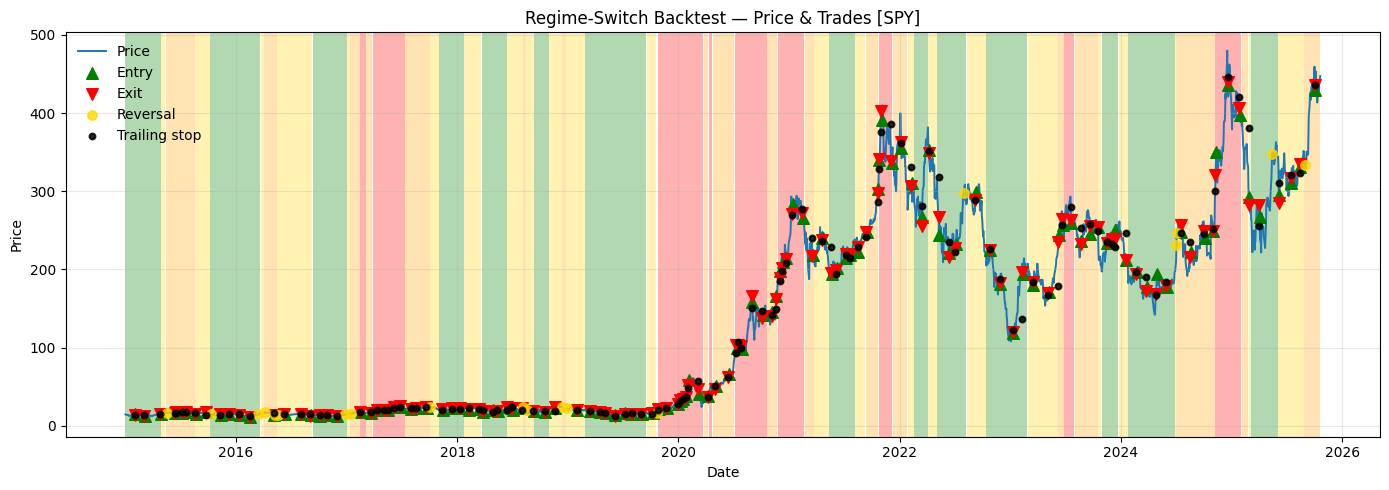

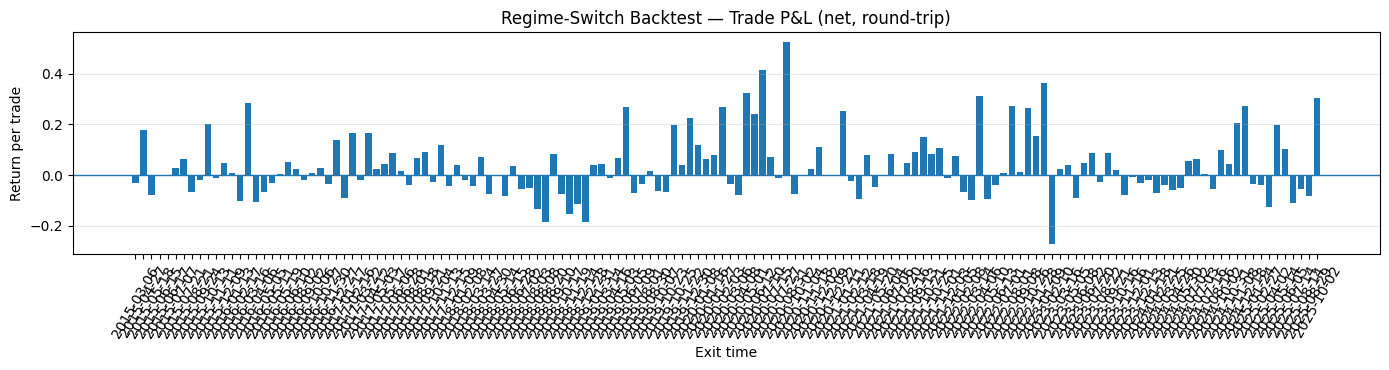

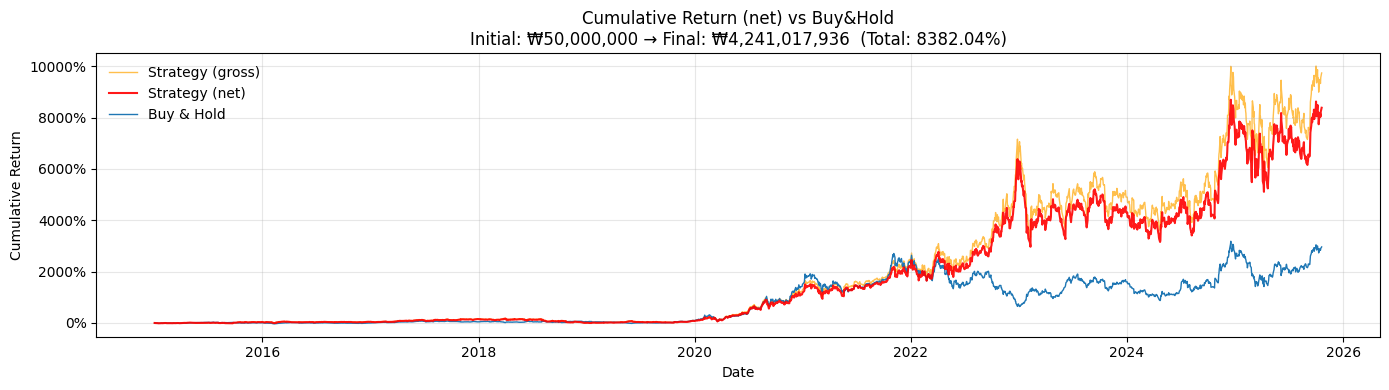

In [28]:
from regime_backtester import RegimeBacktester, BTConfig

cfg = BTConfig(init_capital=50_000_000, fee_bps=5, slip_bps=0, allow_shorts=True)
rb  = RegimeBacktester(config=cfg)

strategies = {
    1: RegimeBacktester.strat_momentum,
    2: RegimeBacktester.strat_momentum,
    3: RegimeBacktester.strat_mean_reversion,
    4: RegimeBacktester.strat_mean_reversion,
}

bt = rb.run_backtest(
    df_out,
    strategies = strategies,
    price_col="Close",
    regime_col="regime",
    start="2015-01-01", end="2025-10-20",
    warmup_bars=200,
    exec_shift=1,
    k_atr=2,                        # High/Low가 있으면 ATR 스톱 사용
    trail_pct=None,                   # (있어도 ATR 경로가 우선됩니다)
    execute_on_trigger_close=True,    # 트리거 ‘당일’ 처리 여부
    execute_price_mode="stop",        # 손절 기준값 설정
    min_gain_to_trail_atr=0.3,
    arm_after_bars=21,
    initial_k_atr=2.0,
    hard_stop_use_entry_atr=True,
)

rb.plot_backtest_with_trades_rainbow(bt, df_out, ticker="SPY")
rb.plot_cum_return_after(bt, title="Cumulative Return (net) vs Buy&Hold")


In [24]:
name_map = RegimeBacktester.make_regime_name_map(strategies)

summary, parts = rb.strategy_attribution(
    bt=bt,
    df_out=df_out,
    regime_col="regime",
    strategies=strategies,
    name_map=name_map,
)

summary


,TotalRet,CAGR,Sharpe(ann.),MaxDD,DaysActive,Contribution(%)
Strategy,,,,,,
regime1_momentum,8.570307,0.232658,0.867240,-0.519302,444.0,9.908686
regime4_mean_reversion,2.189070,0.113381,0.465947,-0.526671,1015.0,2.530925
regime2_momentum,1.990042,0.106756,0.499543,-0.465430,598.0,2.300817
regime3_mean_reversion,-0.027698,-0.002598,0.124357,-0.521689,657.0,-0.032023
__TOTAL__,86.492868,0.514986,0.976061,-0.626808,2714.0,100.000000
